# Fire Radiative Energy to Total Particulate Matter Workbook

This workbook develops the workflow for generating estiamtes of total particulate matter (TPM) from observations of fire radiative energy (FRE).  The FRE observations are derived from time integrated observations of fire radiative power (FRP), which is a measure of the amount of energy emitted by a fire per unit time and has units $Wm^{-2}$.  In order integrate over time we need observations of the FRP through time, and therefore rely on observations of fires from geostrationary sensors, in particular: SEVIRI over Africa/Europe; GOES over North and South America; Himawari over Asia and Oceania.  Which provide observations at 15, 30 and 10 minute intervals respectively.  

The TPM ($gm^{-2}$) observations are required to be instantaneous only, as such they can be derived from polar orbiting sensors.   The TPM estimates are derived from optical depth (OD, unitless) estimates taken from the smoke plumes associated with a fire as the ratio OD to the mass extinction coffecient ($m^{2}g^{-1}$).  As such for TPM we need two parameters.  OD is a commonly retrived parameters from remotely sensed optical imagery, for example MODIS has a number of products which come under the MOD04/MYD04 product classification.  The mass extinction coefficient is typically derived from in-situ observations. 

The basic premise is to develop FRE observations for a set of fires, specifcally selecting fires with clear and definable smoke plumes, calculating the TPM for these plumes and finally deriving a linear relation between the FRE and the TPM.  Once this relation is defined it is then possible to determine the TPM directly from observations of FRE.

Here we explore the development of this relation.

In [1]:
# load in required packages
import ast
import glob
import os
import re
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
from netCDF4 import Dataset
from pyhdf.SD import SD, SDC
from matplotlib.path import Path
from scipy import stats
from scipy import integrate
from shapely.geometry import Polygon, Point
from shapely.ops import transform
from mpl_toolkits.basemap import Basemap
import pyresample as pr
import pyproj

import src.config.filepaths as filepaths
import src.config.sensor as sensor

import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [2]:
root_path = '/Users/dnf/Projects/kcl-fire-aot/data/'

Load in the FRP data:

In [3]:
def load_frp():
    if sensor.sensor == 'himawari':
        try:
            frp_df = pd.read_pickle(filepaths.path_to_himawari_frp + 'himawari_df.p')
        except Exception, e:
            print('could not load frp dataframe, failed with error ' + str(e) + ' building anew')
            frp_files = os.listdir(filepaths.path_to_himawari_frp)
            df_from_each_file = (pd.read_csv(os.path.join(filepaths.path_to_himawari_frp, f)) for f in frp_files)
            frp_df = pd.concat(df_from_each_file, ignore_index=True)

            # lets dump the columns we don't want
            frp_df = frp_df[['FIRE_CONFIDENCE', 'FRP_0', 'LATITUDE', 'LONGITUDE', 'year','month','day','time']]

            # make geocoords into shapely points
            points = [Point(p[0], p[1]) for p in zip(frp_df['LONGITUDE'].values, frp_df['LATITUDE'].values)]
            frp_df['point'] = points
            frp_df.drop(['LONGITUDE', 'LATITUDE'], axis=1, inplace=True)

            # reindex onto date
            for k in ['year', 'month', 'day', 'time']:
                frp_df[k] = frp_df[k].astype(int).astype(str)
                if k == 'time':
                    frp_df[k] = frp_df[k].str.zfill(4)
                if k in ['month', 'day']:
                    frp_df[k] = frp_df[k].str.zfill(2)

            format = '%Y%m%d%H%M'
            frp_df['obs_time'] = pd.to_datetime(frp_df['year'] +
                                             frp_df['month'] +
                                             frp_df['day'] + 
                                             frp_df['time'], format=format)
            frp_df['obs_date'] = frp_df['obs_time'].dt.date
            frp_df.drop(['year','month','day', 'time'], axis=1, inplace=True)
            
            frp_df.to_pickle(filepaths.path_to_himawari_frp + 'himawari_df.p')

    elif sensor.sensor == 'goes':
        pass

    return frp_df
frp_data = load_frp()

Load in the smoke plume masks:

In [11]:
mask_path = root_path + 'Asia/processed/plume_masks/myd021km_plumes_df.pickle'
try:
    mask_df = pd.read_pickle(mask_path)
except:
    mask_df = pd.read_csv(mask_path, quotechar='"', sep=',', converters={'plume_extent': ast.literal_eval})

Here are the funcitons used to compute the FRE from the FRP contained within the plume:

In [6]:
def build_polygon(plume, lats, lons):

    # when digitising points are appended (x,y).  However, arrays are accessed
    # in numpy as row, col which is y, x.  So we need to switch
    bounding_lats = [lats[point[1], point[0]] for point in plume.plume_extent]
    bounding_lons = [lons[point[1], point[0]] for point in plume.plume_extent]

    return Polygon(zip(bounding_lons, bounding_lats))

In [6]:
def compute_fre(plume, frp_data):
    
    # load in lats and lons for plume polygon
    myd_data = SD(os.path.join(filepaths.path_to_modis_l1b, plume.filename), SDC.READ)
    lats = ndimage.zoom(myd_data.select('Latitude').get(), 5)
    lons = ndimage.zoom(myd_data.select('Longitude').get(), 5)
        
    # subset temporally, getting day of overpass and also day before
    plume_date_stop = datetime.strptime(plume.filename[10:17], '%Y%j').date()
    plume_date_start = plume_date_stop - timedelta(days=1)
    try:
        frp_subset = frp_data.loc[(frp_data['obs_date'] == plume_date_stop) | 
                                   (frp_data['obs_date'] == plume_date_start)]
    except Exception, e:
        print 'Could not extract time subset, failed with error:', str(e)
        return None
        
    # subset spatially finding only those fires within the bounds of the plume
    # note Matplotlib path might be a better option to check with bounds
    # see here: https://goo.gl/Cevi1u.  Also, do we need to project first to
    # determine if the points are inside the polygon?  I think not as everything
    # is in, in effect, geographic projection.  So should be fine.
    inbounds = []
    plume_polygon = build_polygon(plume, lats, lons)
    try:
        for i, (index, frp_pixel) in enumerate(frp_subset.iterrows()):
            if frp_pixel['point'].within(plume_polygon):
                inbounds.append(i)
        if inbounds:
            frp_subset = frp_subset.iloc[inbounds]
    except Exception, e:
        print 'Could not extract spatial subset, failed with error:', str(e)
        return None
           
    # group by time and then aggregate the FRP variables appropriately
    frp_subset['FIRE_CONFIDENCE_mean'] = frp_subset['FIRE_CONFIDENCE']
    frp_subset['FIRE_CONFIDENCE_std'] = frp_subset['FIRE_CONFIDENCE']
    frp_subset = frp_subset.groupby('obs_time').agg({'FRP_0':np.sum, 
                                                     'FIRE_CONFIDENCE_mean':np.mean,
                                                    'FIRE_CONFIDENCE_std':np.std})[['FRP_0', 
                                                                                    'FIRE_CONFIDENCE_mean',
                                                                                    'FIRE_CONFIDENCE_std']]
    
    # get the plume observation overpass UTC time
    plume_obs_time = datetime.strptime(re.search('[0-9]{7,7}\.[0-9]{4,4}', plume.filename).group(0), '%Y%j.%H%M')
    plume_obs_time_less_12_hours = plume_obs_time - timedelta(hours=12)
    
    # we can then get all FRPs in the 12 hours before the overpass
    frp_subset = frp_subset[(frp_subset.index <= plume_obs_time) & 
                            (frp_subset.index >= plume_obs_time_less_12_hours)]
    
    # set up the times for integration
    try:
        t0 = frp_subset.index[0]
        sample_times = (frp_subset.index - t0).total_seconds()
    except Exception, e:
        print 'Could not extract spatial subset, failed with error:', str(e)
        return None
 
    # now integrate 
    fre = integrate.trapz(frp_subset['FRP_0'], sample_times)
    print 'fre:', fre
    return fre

Function to compute the area of the plume:

In [13]:
def compute_plume_area(plume):
    
    myd_data = SD(os.path.join(filepaths.path_to_modis_l1b, plume.filename), SDC.READ)
    lats = ndimage.zoom(myd_data.select('Latitude').get(), 5)
    lons = ndimage.zoom(myd_data.select('Longitude').get(), 5)
    
    # build shapely polygon
    plume_polygon = build_polygon(plume, lats, lons)
    
    # TODO is sinusoidal proj good enough?  Yes it is: https://goo.gl/KE3tuY
    # get extra accuracy by selecting an appropriate lon_0
    m = Basemap(projection='sinu',lon_0=140,resolution='c')
    
    # apply to shapely polygon
    projected_plume_polygon = transform(m, plume_polygon)
    
    # compute projected polygon area in m2
    return projected_plume_polygon.area 

Functions to compute AOD for the plume:

In [34]:
def bounding_pixel_coords(plume):
    padding = 3  # pixels
    x, y = zip(*plume.plume_extent)
    min_x, max_x = np.min(x)-padding, np.max(x)+padding
    min_y, max_y = np.min(y)-padding, np.max(y)+padding
    return {'max_x': max_x, 'min_x': min_x, 'max_y': max_y, 'min_y': min_y}

In [35]:
def define_plume_mask(plume, bounds):
    
    extent = [[x - bounds['min_x'], y - bounds['min_y']] for x, y in plume.plume_extent]

    size_x = bounds['max_x'] - bounds['min_x']
    size_y = bounds['max_y'] - bounds['min_y']
    x, y = np.meshgrid(np.arange(size_x), np.arange(size_y))
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x, y)).T
    
    # create mask
    path = Path(extent)
    mask = path.contains_points(points)
    mask = mask.reshape((size_y, size_x))

    return mask

In [36]:
class resampler(object):
    def __init__(self, lats, lons):
        self.lats = lats
        self.lons = lons
        self.map_def = self.__utm_map()
        
    def __geographic_map(self):
        lat_range = np.arange(np.min(self.lats), np.max(self.lats), 0.01)  # lets reproject to 0.01 degree geographic grid
        lon_range = np.arange(np.min(self.lons), np.max(self.lons), 0.01)
        lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
        return pr.geometry.SwathDefinition(lons=lon_grid, lats=lat_grid)

    def __utm_zone(self):
        '''
        Some of the plumes will cross UTM zones.  This is not problematic
        as the plumes are quite small and so, we can just use the zone
        in which most of the data falls: https://goo.gl/3QY2Re
        see also: http://www.igorexchange.com/node/927 for if we need over Svalbard (highly unlikely)
        '''
        lons = (self.lons+180)-np.floor((self.lons+180)/360)*360-180;
        return stats.mode(np.floor((lons + 180)/6) + 1, axis=None)[0][0]
    
    def __utm_boundaries(self, zone):
        p = pyproj.Proj(proj='utm', zone=zone, ellps='WGS84')
        x, y = p(self.lons, self.lats)
        padding = 3000  # metres  
        min_x, max_x = np.min(x)-padding, np.max(x)+padding
        min_y, max_y = np.min(y)-padding, np.max(y)+padding
        return {'max_x': max_x, 'min_x': min_x, 'max_y': max_y, 'min_y': min_y}
    
    def __utm_grid_size(self, utm_boundaries):
        pixel_size = 1000  # desried approximate pixel size metres 
        x_size = int(np.ceil((utm_boundaries['max_x'] - utm_boundaries['min_x']) / pixel_size))
        y_size = int(np.ceil((utm_boundaries['max_y'] - utm_boundaries['min_y']) / pixel_size))
        return x_size, y_size
    
    def __utm_proj(self, zone, utm_boundaries, x_size, y_size):
        area_id = 'utm'
        description = 'utm_grid'
        proj_id = 'utm'
        area_extent = (utm_boundaries['min_x'], utm_boundaries['min_y'], 
                       utm_boundaries['max_x'], utm_boundaries['max_y'])
        proj_dict = {'units': 'm', 'proj':'utm', 'zone': str(zone), 'ellps': 'WGS84', 'datum': 'WGS84'}        
        return pr.geometry.AreaDefinition(area_id, description, proj_id, proj_dict, x_size, y_size, area_extent)

    def __utm_map(self):
        zone = self.__utm_zone()
        utm_boundaries = self.__utm_boundaries(zone)
        x_size, y_size = self.__utm_grid_size(utm_boundaries)
        return self.__utm_proj(zone, utm_boundaries, x_size, y_size)
            
    def resample_image(self, image, image_lats, image_lons):
        image_def = pr.geometry.SwathDefinition(lons=image_lons, lats=image_lats)
        return pr.kd_tree.resample_nearest(image_def,
                                           image,
                                           self.map_def,
                                           radius_of_influence=9000,
                                           fill_value=-999)

In [37]:
def compute_aod():
    
    '''
    Resampling of the ORAC AOD data is required to remove the bowtie effect from the data.  We can then
    sum over the AODs contained with the plume.
    
    Resampling of the MODIS AOD data is required so that it is in the same projection as the ORAC AOD.  
    With it being in the same projection we can replace low quality ORAC AODs with those from MXD04 products.  
    We also need to get the background AOD data from MXD04 products as ORAC does not do optically thin
    retrievals well.  
    
    Also, we need to check that the pixel area estimates being computed by compute_plume_area are reasonable.
    That can be done in this function, we just produce another area estimate from the resampled mask by getting 
    vertices, getting the lat lons of the vertices, creating a shapely polygon from them and then computing the area.
    '''
    
    # get bounds (plume bounding rectanble, buffered by a certain extent)
    plume_bounding_pixels = bounding_pixel_coords(plume)
    
    # get the plume mask
    plume_mask = define_plume_mask(plume, plume_bounding_pixels)
    
    # get the resampler
    myd_data = SD(os.path.join(filepaths.path_to_modis_l1b, plume.filename), SDC.READ)
    lats = ndimage.zoom(myd_data.select('Latitude').get(), 5)[plume_bounding_pixels['min_y']:plume_bounding_pixels['max_y'], 
                                                              plume_bounding_pixels['min_x']:plume_bounding_pixels['max_x']]
    lons = ndimage.zoom(myd_data.select('Longitude').get(), 5)[plume_bounding_pixels['min_y']:plume_bounding_pixels['max_y'], 
                                                              plume_bounding_pixels['min_x']:plume_bounding_pixels['max_x']]
    im_resampler = resampler(lats, lons)  
    
    # resample the datasets (mask, orac_aod, MYD04)
    resampled_plume_mask = im_resampler.resample_image(plume_mask, lats, lons)
    plt.imshow(resampled_plume_mask, cmap='gray')
    plt.show()
    
    # create best AOD map from ORAC and MYD04 AOD
    
    # extract best AOD using plume mask
    
    # split into background and plume AODs
    
    # subtract background from plume
    
    # return plume AOD
    
    

Code to run the various functions:

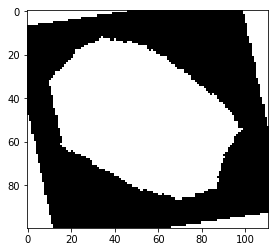

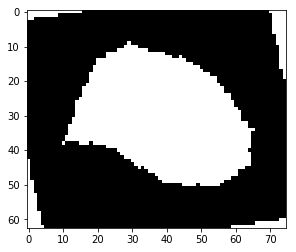

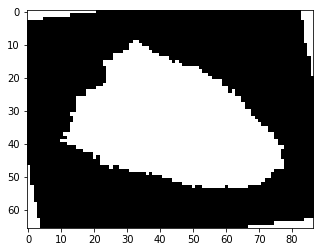

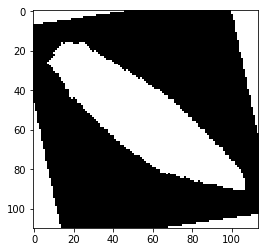

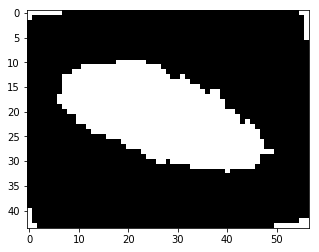

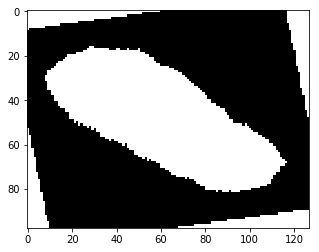

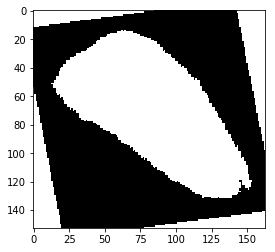

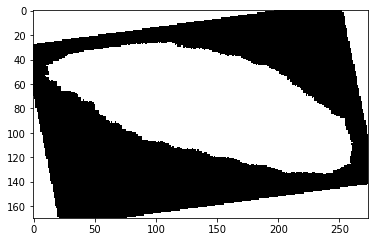

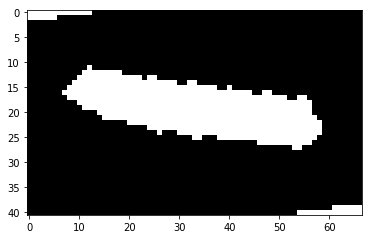

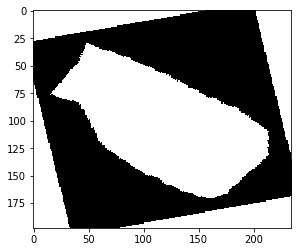

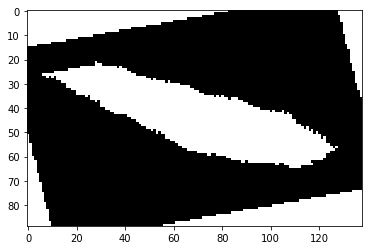

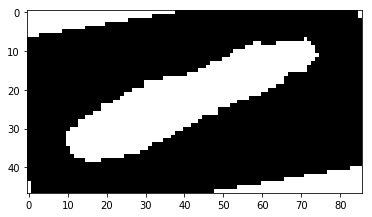

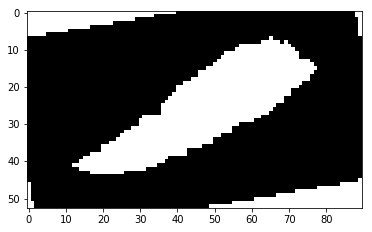

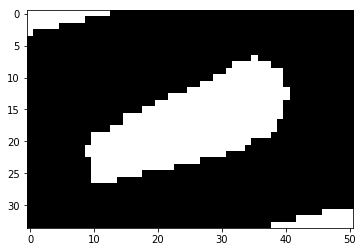

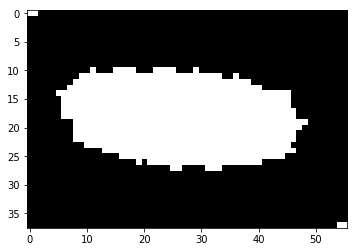

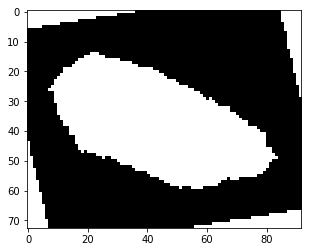

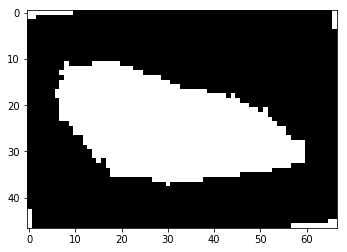

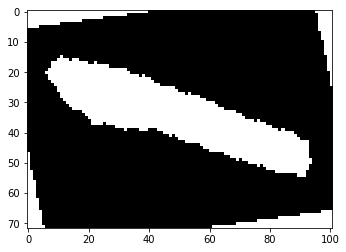

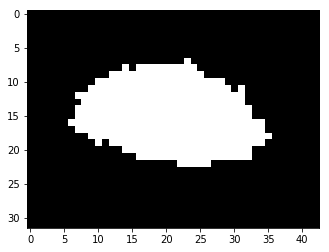

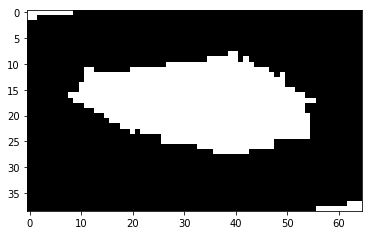

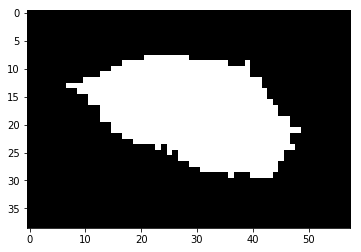

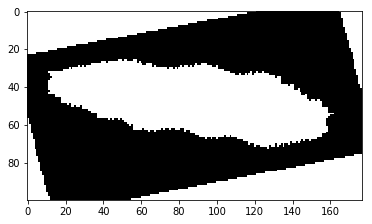

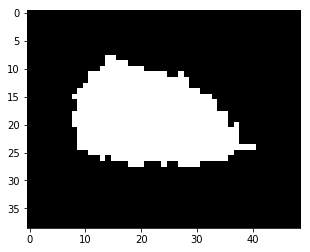

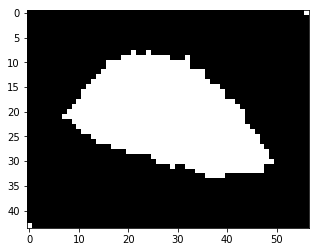

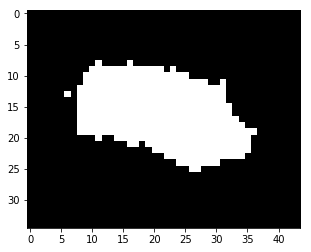

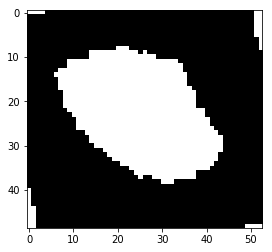

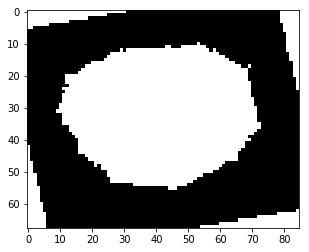

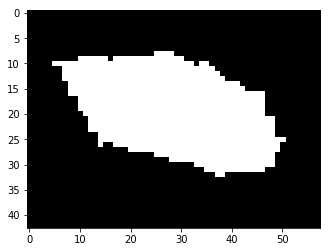

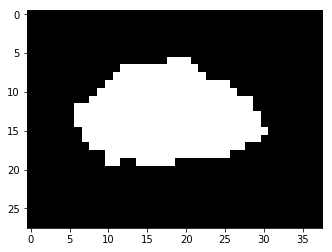

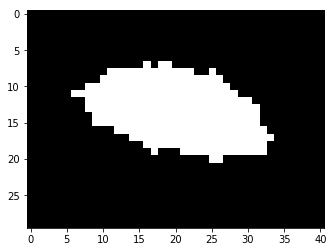

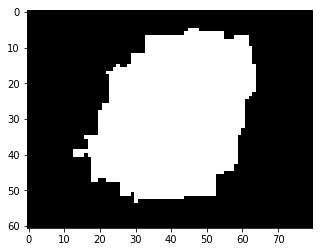

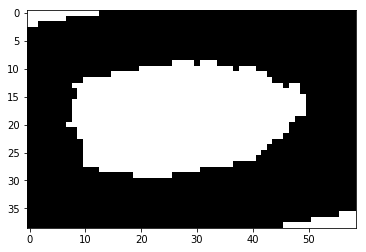

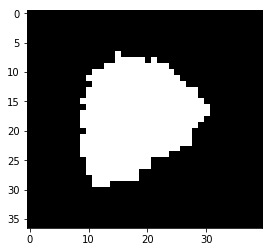

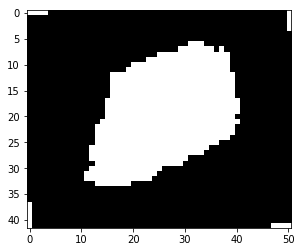

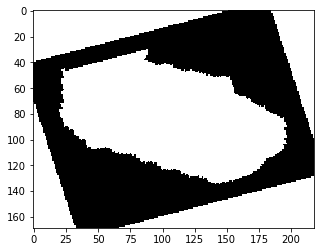

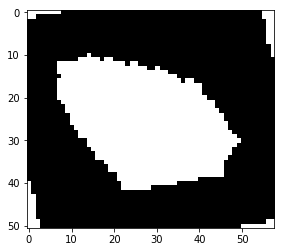

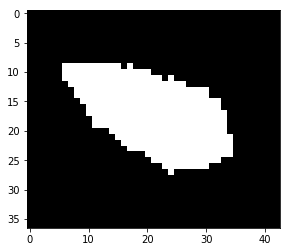

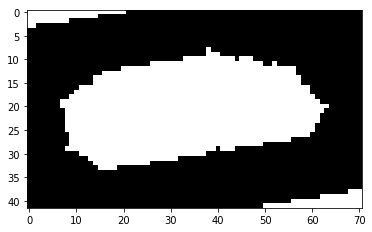

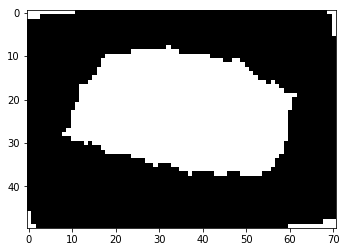

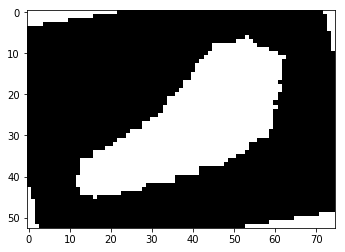

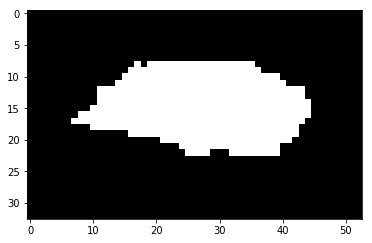

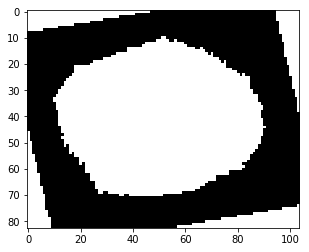

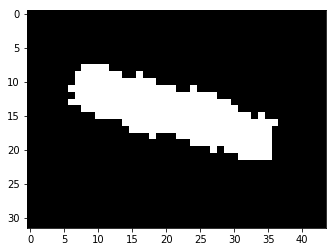

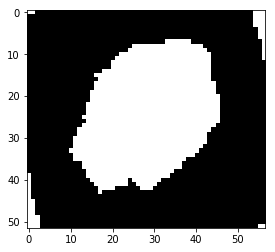

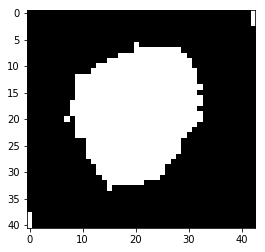

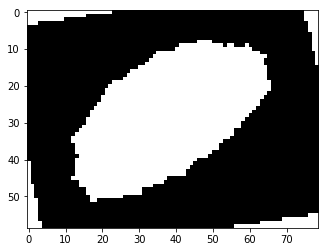

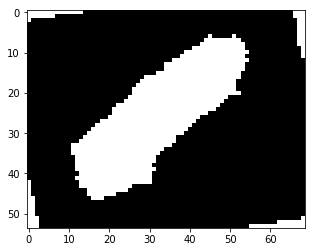

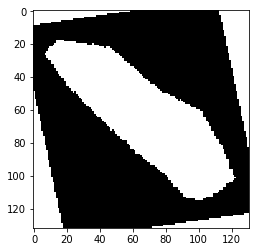

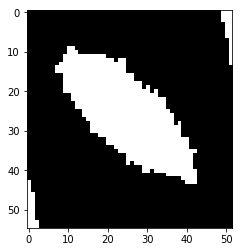

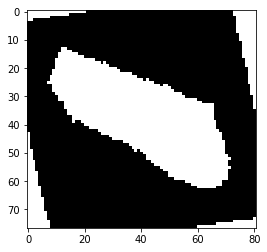

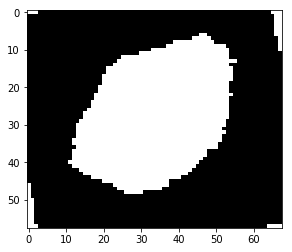

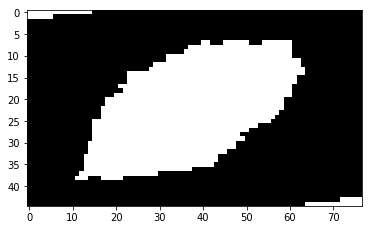

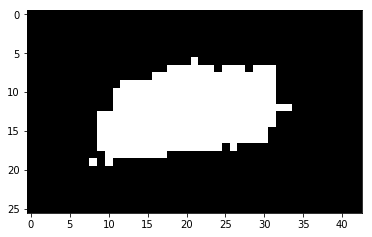

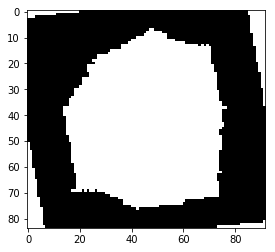

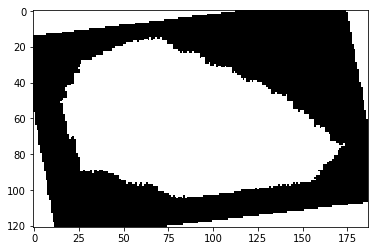

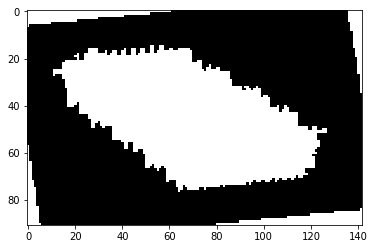

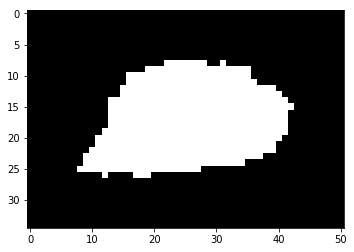

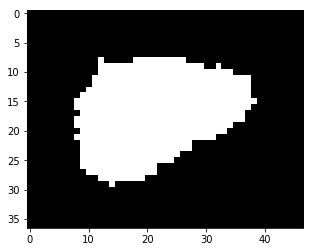

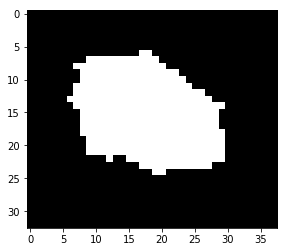

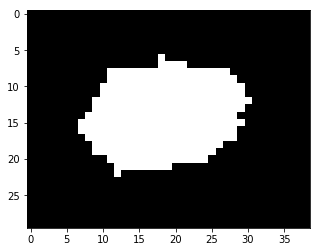

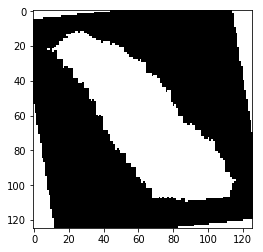

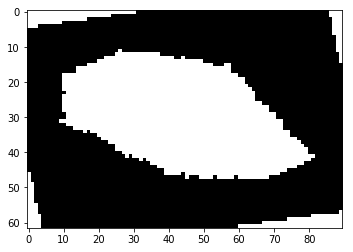

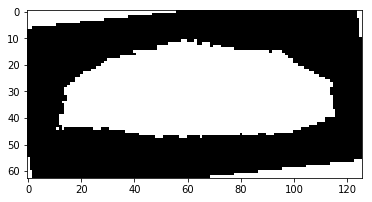

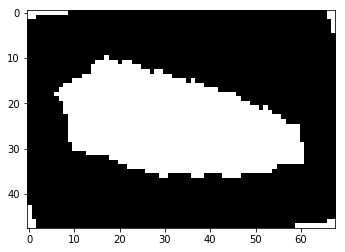

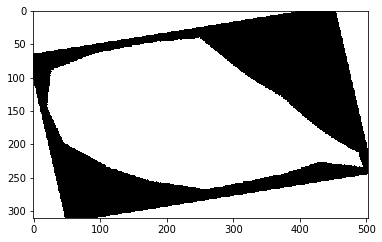

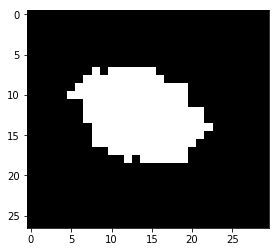

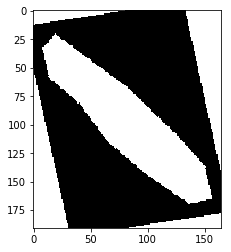

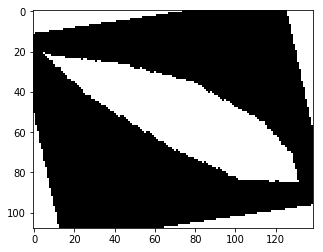

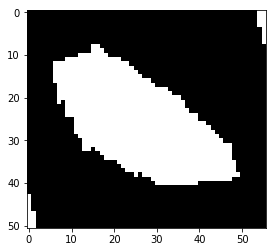

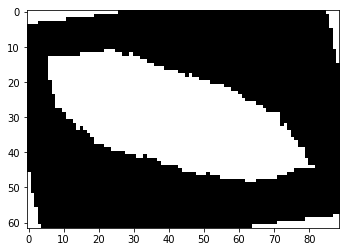

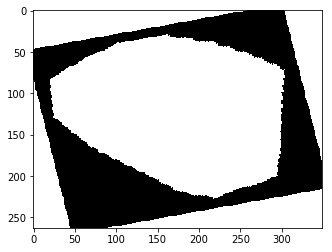

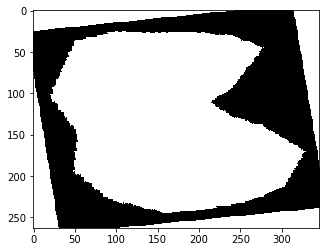

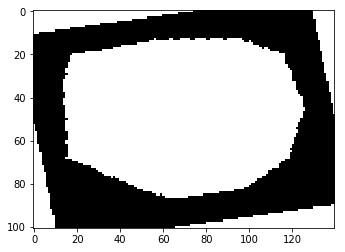

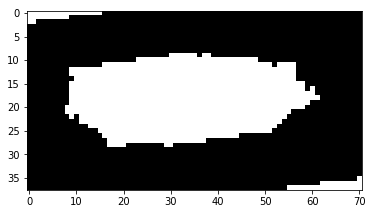

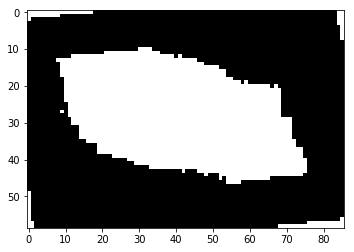

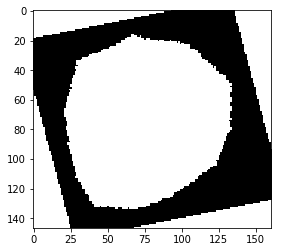

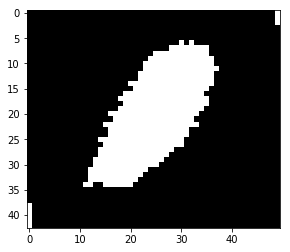

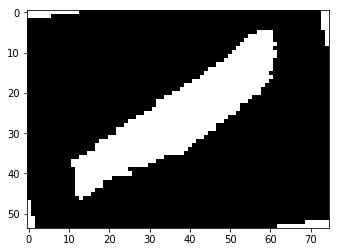

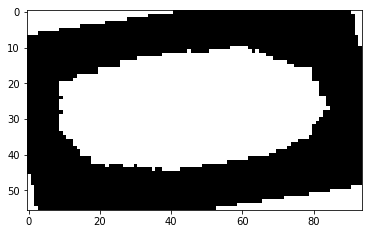

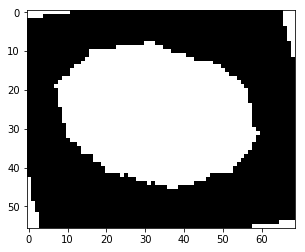

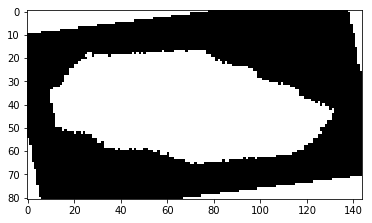

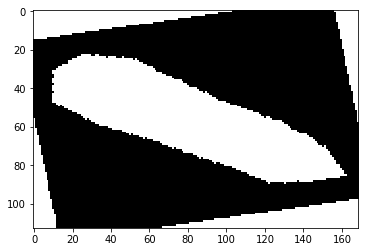

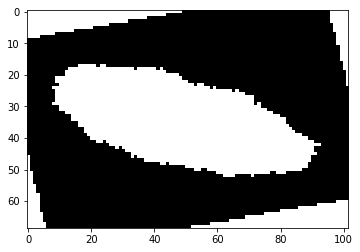

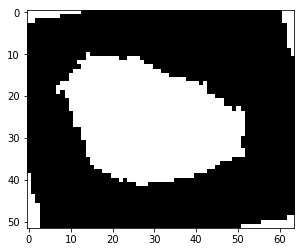

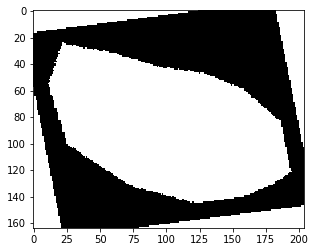

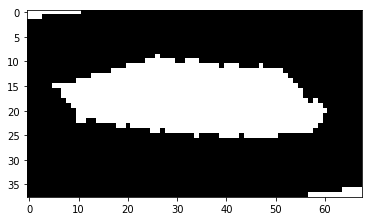

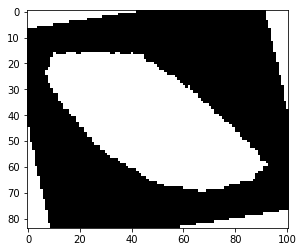

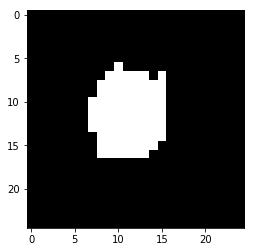

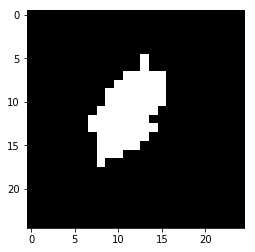

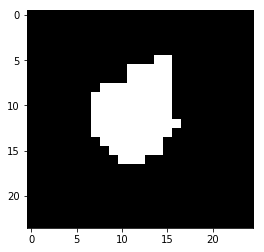

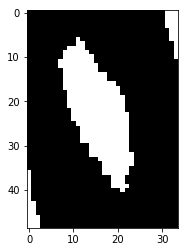

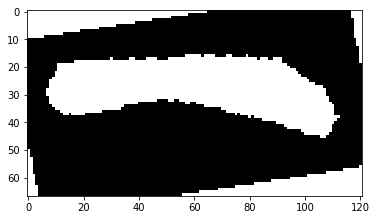

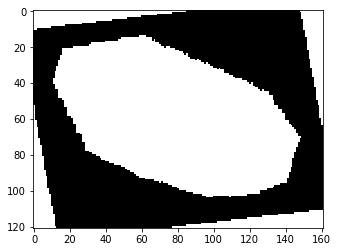

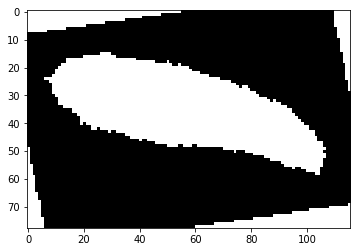

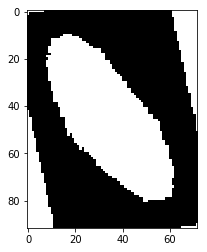

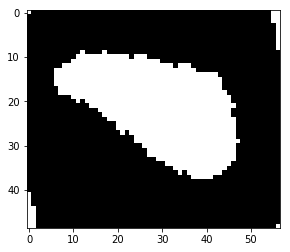

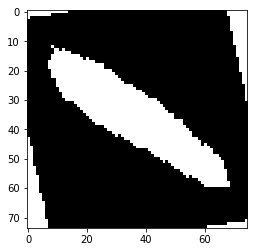

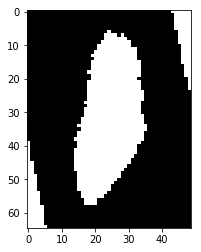

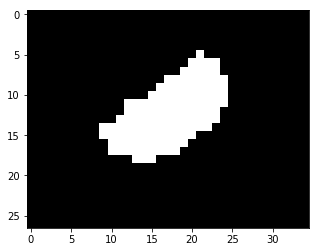

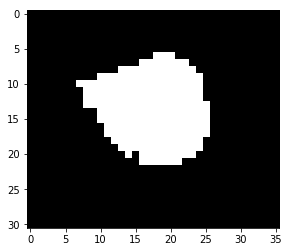

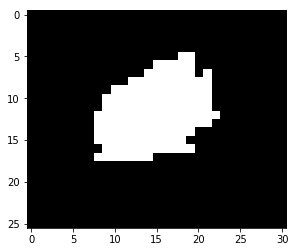

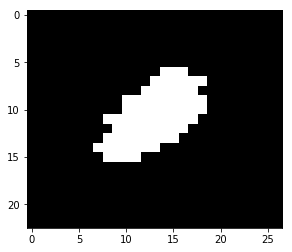

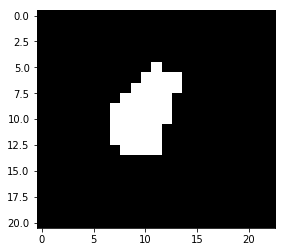

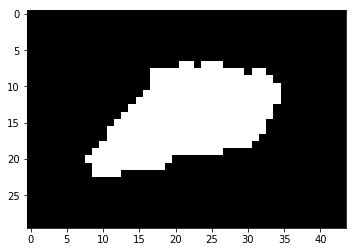

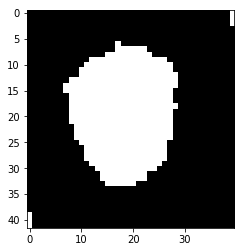

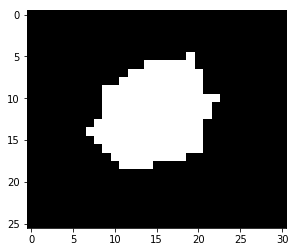

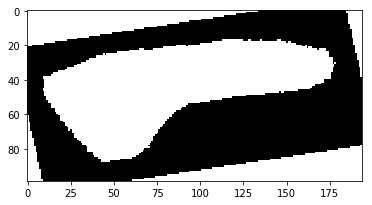

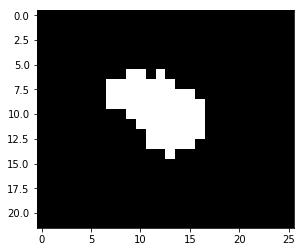

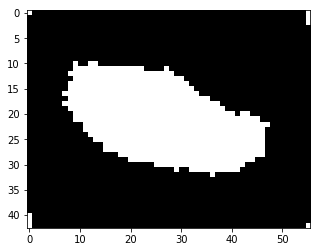

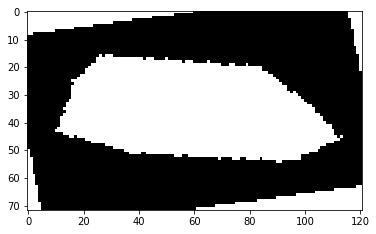

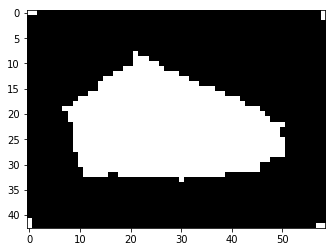

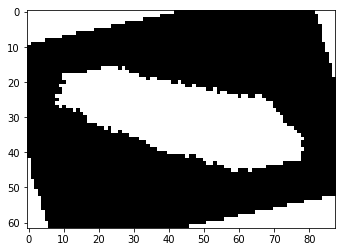

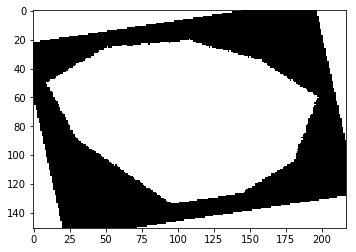

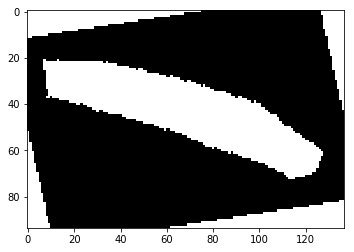

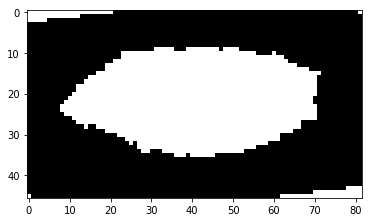

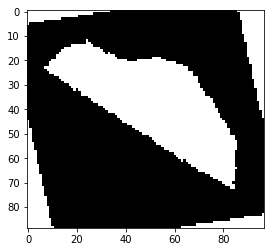

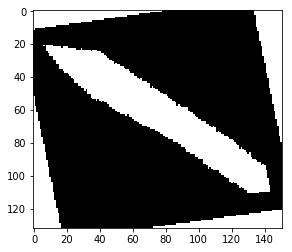

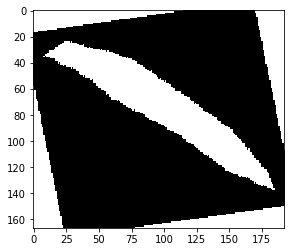

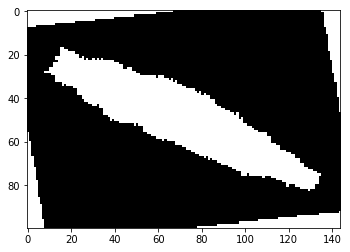

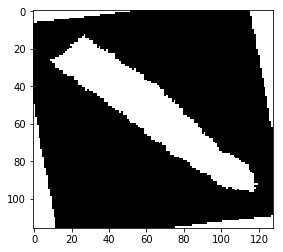

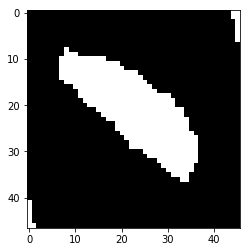

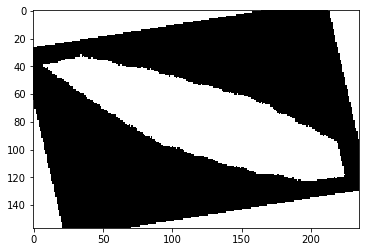

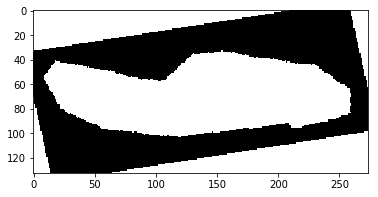

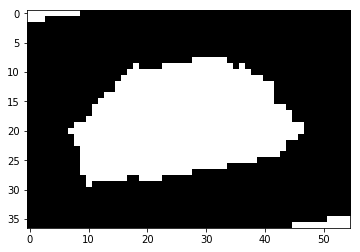

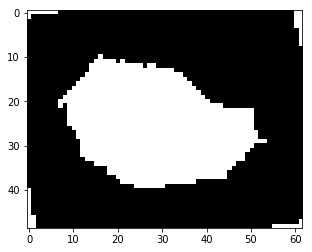

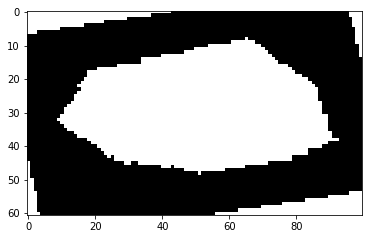

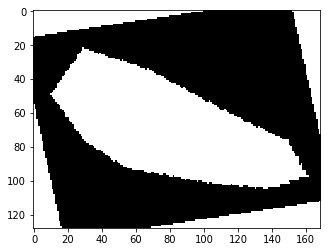

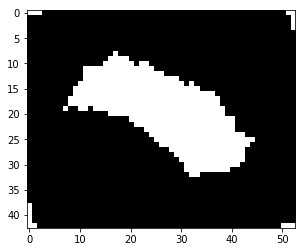

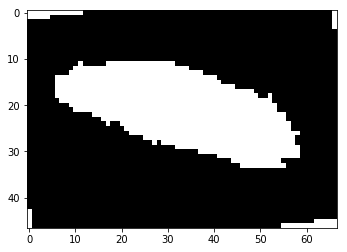

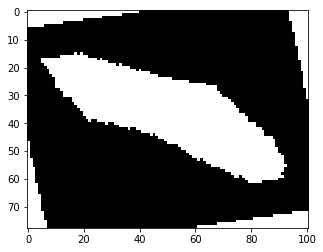

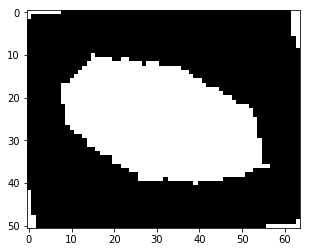

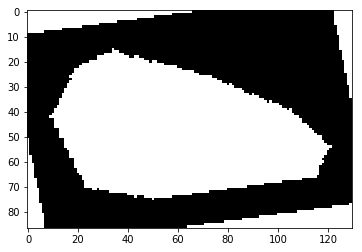

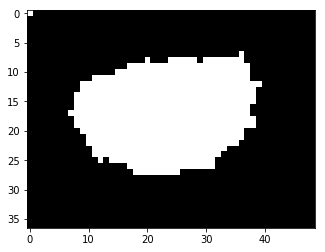

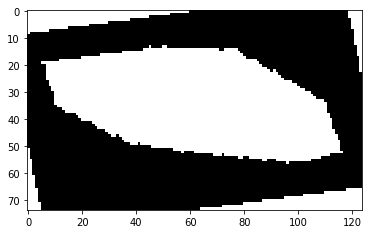

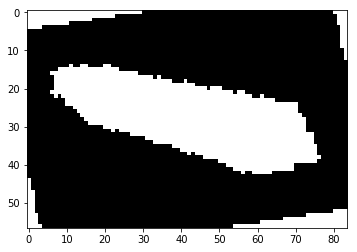

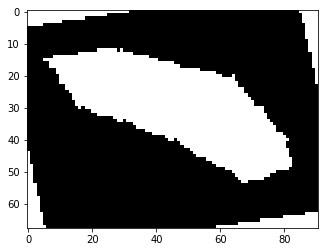

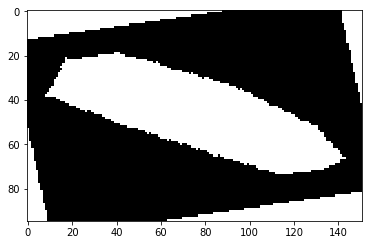

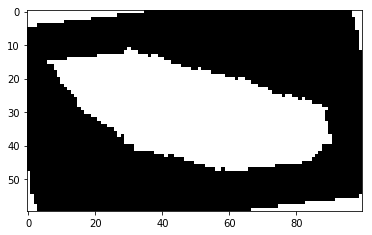

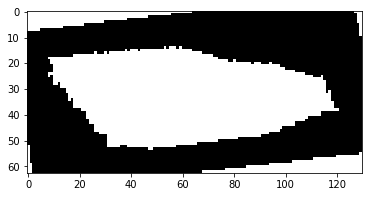

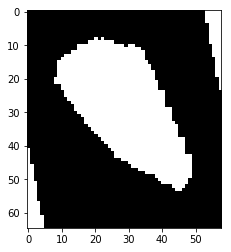

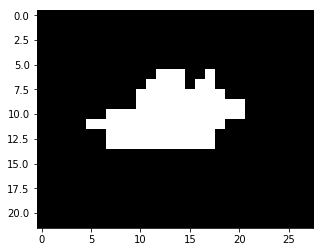

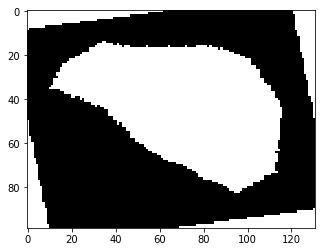

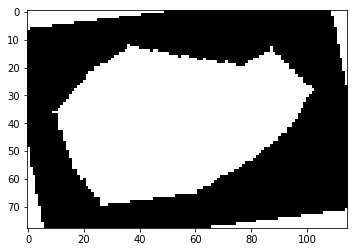

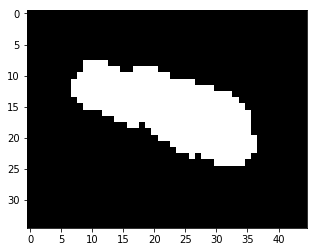

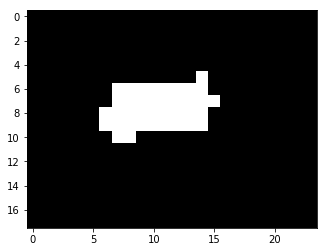

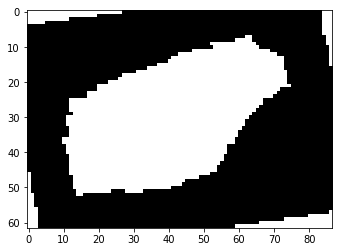

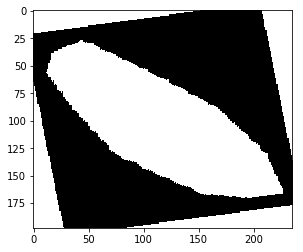

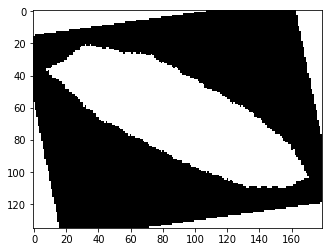

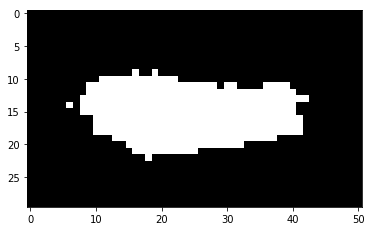

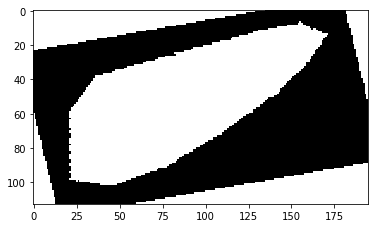

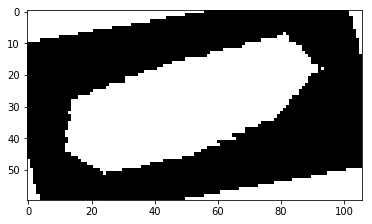

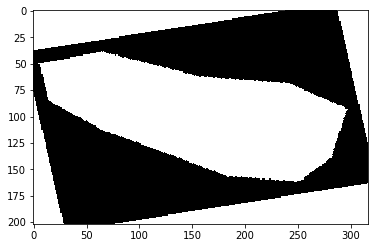

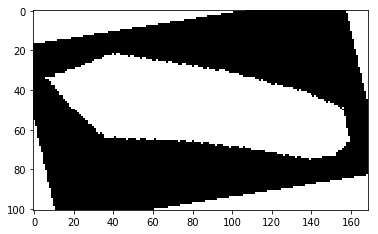

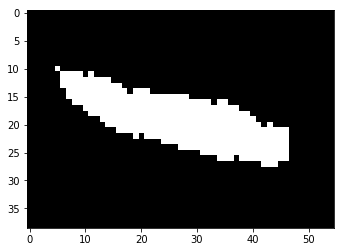

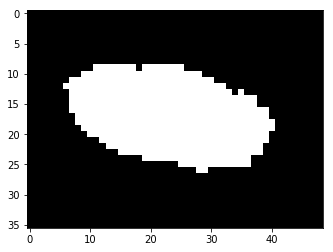

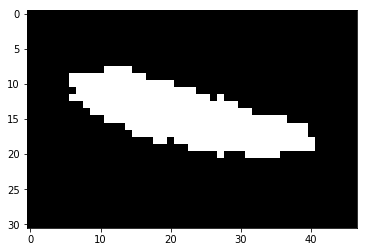

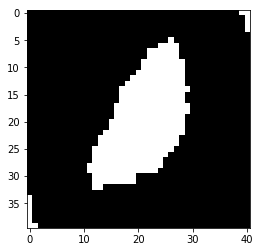

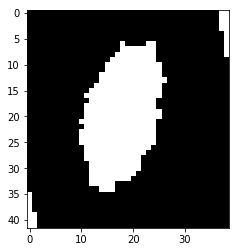

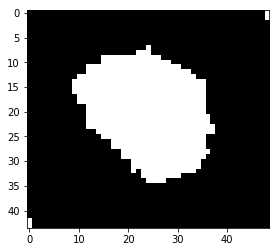

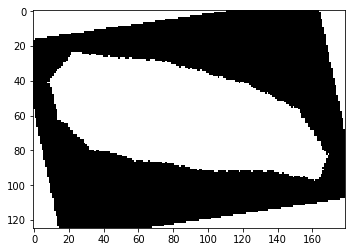

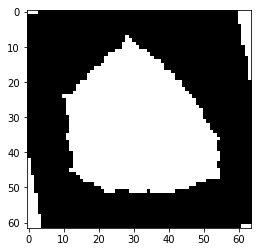

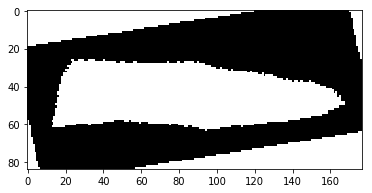

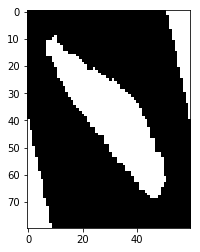

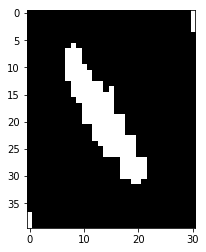

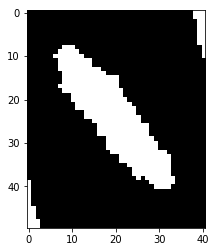

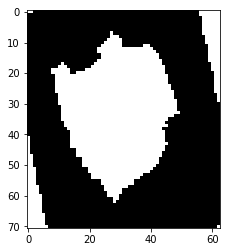

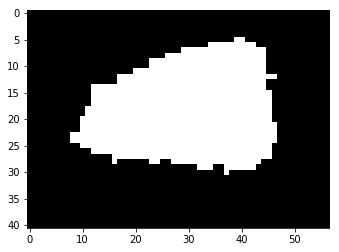

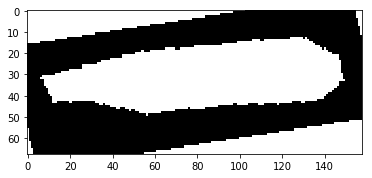

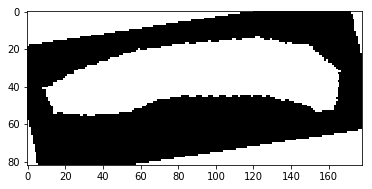

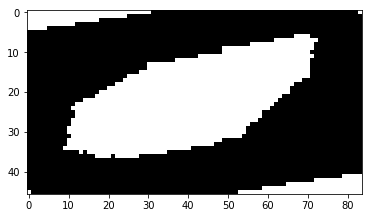

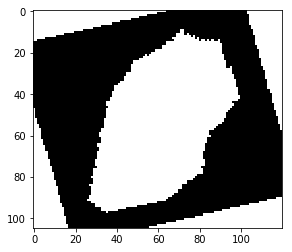

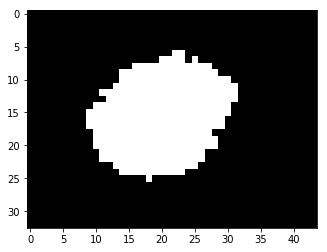

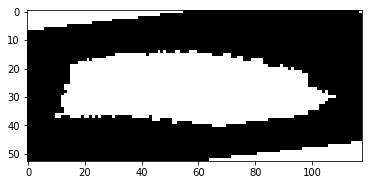

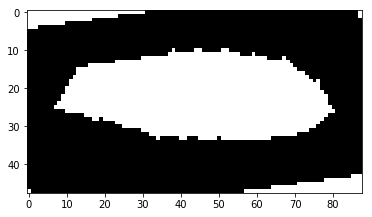

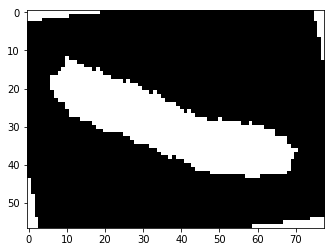

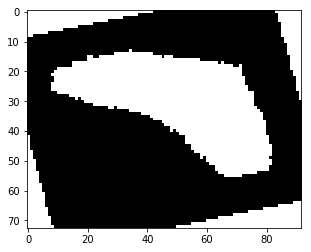

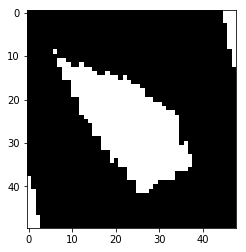

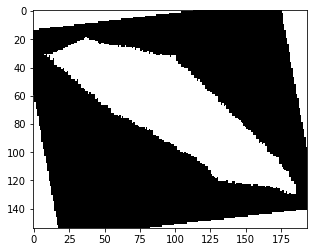

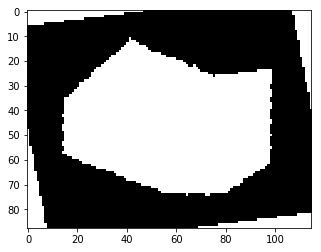

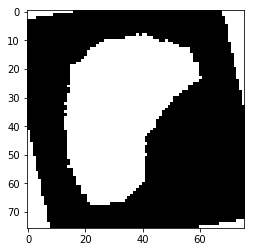

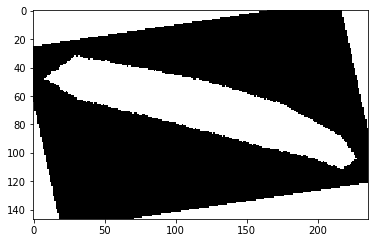

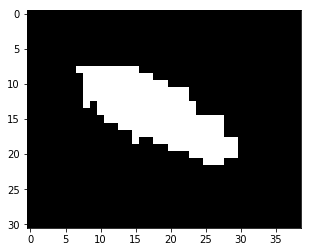

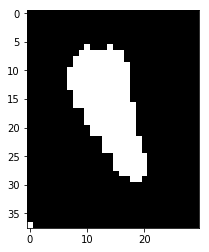

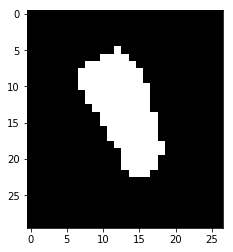

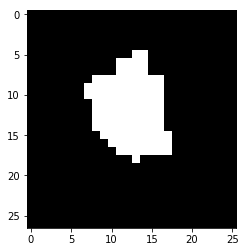

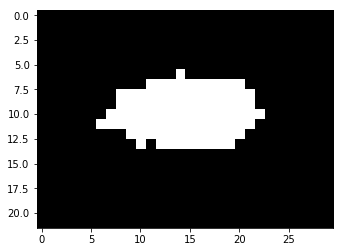

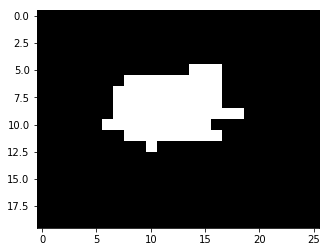

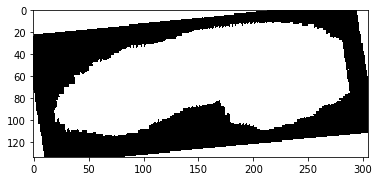

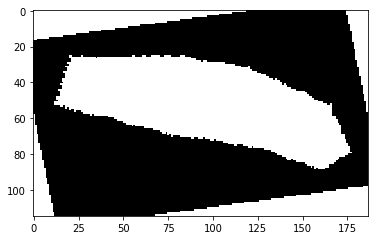

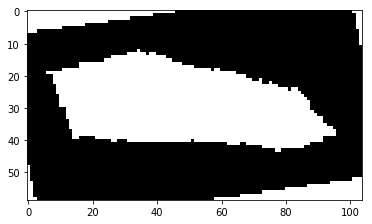

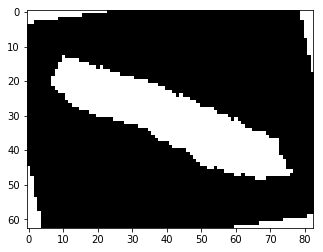

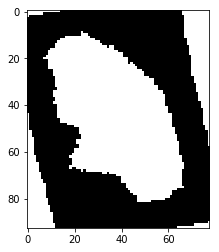

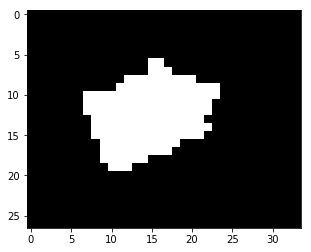

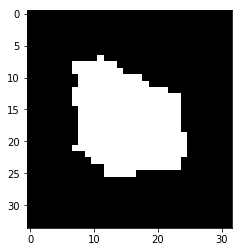

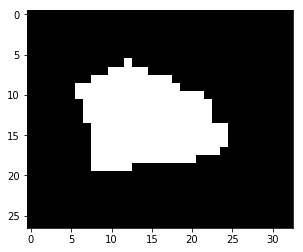

HDF4Error: SD (7): Error opening file

In [38]:
for index, plume in mask_df.iterrows():
    
    # get collocated FRP data
    #fre = compute_fre(plume, frp_data)
    
    # get area of the plume
    #plume_area = compute_plume_area(plume)
    
    # get plume AOD
    total_aod = compute_aod()
